# Benchmark model for transaction recovery project

## Install dependecies

In [4]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1


In [5]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer

import boto3
from time import gmtime, strftime
import numpy as np
import json 

import matplotlib.pyplot as plt 
import seaborn as sns


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
import pandas as pd


## Identify and encode categorical columns

In [201]:

categorical_columns = ['country', 'gender', 'subscription_tier'] 
one_hot_encoder = OneHotEncoder(sparse_output=False)
directory = 'data'
files = ['train', 'validate', 'test']

for file_name in files:
    df = pd.read_csv(directory + "/" + file_name + '.csv')
    encoded_features = pd.DataFrame(one_hot_encoder.fit_transform(df[categorical_columns]))
    df = df.drop(categorical_columns, axis=1)
    df = pd.concat([df, encoded_features], axis=1)
    columns = ['failed'] + [col for col in df if col != 'failed']
    df = df[columns]    
    print (df.head())
    df.to_csv(directory + "/" + file_name + '_lr.csv', index=False, header=False)
    if file_name == 'test':
        df = df.drop(df.columns[0], axis=1)
        df.to_csv(directory + "/" + file_name + '_lr_predict.csv', index=False, header=False)



   failed  age  tenure  products_number  credit_card  active_member  amount  \
0       0   41       2                2            1              1  123.55   
1       1   54       4                1            1              0  126.46   
2       0   30       8                2            0              1   93.47   
3       0   50       7                2            1              1  129.06   
4       0   37       6                1            1              0   84.57   

   engagement_score  billing_failure_count    0    1    2    3    4    5    6  \
0              48.0                      1  0.0  1.0  0.0  0.0  1.0  1.0  0.0   
1              26.0                      2  0.0  1.0  0.0  1.0  0.0  0.0  0.0   
2              72.0                      1  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
3              68.0                      5  0.0  0.0  1.0  0.0  1.0  1.0  0.0   
4              34.0                      2  1.0  0.0  0.0  0.0  1.0  1.0  0.0   

     7  
0  0.0  
1  1.0  
2  1.0  
3 

In [9]:
df.head()

NameError: name 'df' is not defined

## Check columns type 

In [202]:
print(df.dtypes)


age                        int64
tenure                     int64
products_number            int64
credit_card                int64
active_member              int64
amount                   float64
engagement_score         float64
billing_failure_count      int64
0                        float64
1                        float64
2                        float64
3                        float64
4                        float64
5                        float64
6                        float64
7                        float64
dtype: object


## Generate train / test / validate files and  upload data to S3

In [203]:
## Upload to S3
import pandas as pd

# Load the dataset
df = pd.read_csv("data/test_lr.csv", header=None)

# Check for inconsistent rows
# row_lengths = df.apply(lambda x: len(x), axis=1)
# inconsistent_rows = row_lengths[row_lengths != row_lengths.iloc[0]]
print(f"Inconsistent rows:\n{inconsistent_rows}")
print(f"Number of columns: {df.shape[1]}")


Inconsistent rows:
Series([], dtype: int64)
Number of columns: 17


In [204]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = "arn:aws:iam::190647331505:role/saba-sagemaker"

print("AWS role: {}".format(role))
bucket= "saba-transaction-data"
print("Default Bucket: {}".format(bucket))

region = "us-east-1"
print("AWS Region: {}".format(region))

train_path = sagemaker_session.upload_data(path="data/train_lr.csv", bucket=bucket, key_prefix='data')
print("train_path: {}".format(train_path))
test_path = sagemaker_session.upload_data(path="data/test_lr.csv", bucket=bucket, key_prefix='data')
test_predict_path = sagemaker_session.upload_data(path="data/test_lr_predict.csv", bucket=bucket, key_prefix='data')
val_path = sagemaker_session.upload_data(path="data/validate_lr.csv", bucket=bucket, key_prefix='data')

AWS role: arn:aws:iam::190647331505:role/saba-sagemaker
Default Bucket: saba-transaction-data
AWS Region: us-east-1
train_path: s3://saba-transaction-data/data/train_lr.csv


## Train Linear Regression as the first benchmark

In [205]:
import sagemaker
from sagemaker import image_uris

sagemaker_session = sagemaker.Session()

linear_estimator = sagemaker.estimator.Estimator(
    image_uri=image_uris.retrieve(framework='linear-learner', region=region),
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/output',
    sagemaker_session=sagemaker_session, 
    enable_sagemaker_metrics=True, 
    debug_hook_config=True
)

print("created Estimator")
 
# Set hyperparameters for LinearLearner
linear_estimator.set_hyperparameters(
    feature_dim=16,  # Number of features (change this based on your dataset)
    predictor_type='regressor',
    mini_batch_size=100,
    epochs=10 
)
print("set hyperparameters")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


created Estimator
set hyperparameters


In [206]:
from sagemaker.inputs import TrainingInput

train_data = TrainingInput(s3_data=train_path, content_type='text/csv')
validate_data = TrainingInput(s3_data=val_path, content_type='text/csv')

# Train the model
linear_estimator.fit({'train': train_data, 'validation': validate_data})


INFO:sagemaker:Creating training-job with name: linear-learner-2024-12-13-02-21-13-885


2024-12-13 02:21:15 Starting - Starting the training job...
2024-12-13 02:21:30 Starting - Preparing the instances for training...
2024-12-13 02:22:01 Downloading - Downloading input data...
2024-12-13 02:22:41 Downloading - Downloading the training image........Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/13/2024 02:24:07 INFO 139805544339264] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '0.01', 'huber_delta':

## Create and register model Linear Estimator

In [207]:
model_name = linear_estimator.latest_training_job.name  # Training job name often serves as model name
print(f"Model Name: {model_name}")

training_job_desc = linear_estimator.latest_training_job.describe()

# Retrieve the S3 URI for the model artifact
model_artifact = training_job_desc["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model Artifact S3 URI: {model_artifact}")

# Retrieve the Docker image URI used for the training job
image_uri = training_job_desc["AlgorithmSpecification"]["TrainingImage"]
print(f"Image URI: {image_uri}")

Model Name: linear-learner-2024-12-13-02-21-13-885
Model Artifact S3 URI: s3://saba-transaction-data/output/linear-learner-2024-12-13-02-21-13-885/output/model.tar.gz
Image URI: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [208]:
#Register model
from sagemaker import Model

# Get the training job name
training_job_name = linear_estimator.latest_training_job.name


# Create the model
model = Model(
    model_data=model_artifact,  
    role=role, # same role as in training
    image_uri=image_uri,
)

# Register the model
model.name = training_job_name
model.create()

print(f"Model {training_job_name} registered successfully!")


INFO:sagemaker:Creating model with name: linear-learner-2024-12-13-02-21-13-885


Model linear-learner-2024-12-13-02-21-13-885 registered successfully!


### Use Liner Estimator model to run batch transform and generate scoring results for unseen transactions

In [209]:
from sagemaker.transformer import Transformer

transformer = Transformer(
    model_name=training_job_name,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path="s3://saba-transaction-data/output",
)

transformer.transform(
    data="s3://saba-transaction-data/data/test_lr_predict.csv",  # Test dataset in S3
    content_type="text/csv",
    split_type="Line",
)

transformer.wait()


INFO:sagemaker:Creating transform job with name: linear-learner-2024-12-13-02-26-08-270


.................................Docker entrypoint called with argument(s): serve
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[12/13/2024 02:32:00 INFO 139764278257472] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
Running default environment configuration script
[12/13/2024 02:32:00 INFO 139764278257472] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_

### Evaluate Liner Estimator model, use several thresholds to find the best value

In [214]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the predictions file
predictions_df = pd.read_json('data/test_lr_predict.csv.out', lines=True)

# Load the ground truth file without headers
ground_truth_df = pd.read_csv("data/test_lr.csv", header=None)


# Assume the last column in the ground truth file is the target column
target_column = ground_truth_df.columns[0]

# Adjust the threshold (e.g., 30.0)
for threshold in [0.20, 0.25, 0.30, 0.50]:
    predictions_df['predicted_label'] = (predictions_df['score'] > threshold).astype(int)
    
    # Combine predictions with ground truth data
    ground_truth_df['predicted_value'] = predictions_df['predicted_label']
    #print (ground_truth_df)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    precision = precision_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    recall = recall_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    f1 = f1_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    conf_matrix = confusion_matrix(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    
    print(f"Threshold: {threshold}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Confusion Matrix:")
    print(conf_matrix)


Threshold: 0.2
Accuracy: 0.6184276414621933
Precision: 0.33365570599613154
Recall: 0.8253588516746412
F1-Score: 0.47520661157024796
Confusion Matrix:
[[890 689]
 [ 73 345]]
Threshold: 0.25
Accuracy: 0.7085628442663996
Precision: 0.39238845144356954
Recall: 0.715311004784689
F1-Score: 0.5067796610169492
Confusion Matrix:
[[1116  463]
 [ 119  299]]
Threshold: 0.3
Accuracy: 0.7681522283425137
Precision: 0.45871559633027525
Recall: 0.5980861244019139
F1-Score: 0.5192107995846313
Confusion Matrix:
[[1284  295]
 [ 168  250]]
Threshold: 0.5
Accuracy: 0.8087130696044066
Precision: 0.7045454545454546
Recall: 0.14832535885167464
F1-Score: 0.2450592885375494
Confusion Matrix:
[[1553   26]
 [ 356   62]]


In [216]:
ground_truth_df = pd.read_csv("data/train_lr.csv", header=None)

print(ground_truth_df.dtypes)
print("Train target unique values:", ground_truth_df[16].unique())
ground_truth_df = pd.read_csv("data/validate_lr.csv", header=None)

print(ground_truth_df.dtypes)
print("Train target unique values:", ground_truth_df[16].unique())



0       int64
1       int64
2       int64
3       int64
4       int64
5       int64
6     float64
7     float64
8       int64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
dtype: object
Train target unique values: [0. 1.]
0       int64
1       int64
2       int64
3       int64
4       int64
5       int64
6     float64
7     float64
8       int64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
dtype: object
Train target unique values: [0. 1.]


## Train Logistic Regression model

In [217]:

print("Creating logistic regression estimator")

logistic_estimator = sagemaker.estimator.Estimator(
    image_uri=image_uris.retrieve(framework='linear-learner', region=region),
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/output',
    sagemaker_session=sagemaker_session,
    enable_sagemaker_metrics=True, 
    debug_hook_config=True
)

print("Setting hyperparameters for logistic regression")
logistic_estimator.set_hyperparameters(
    feature_dim=16,  # Update based on your dataset's number of features
    predictor_type='binary_classifier',
    mini_batch_size=100,
    epochs=10,
    binary_classifier_model_selection_criteria='cross_entropy_loss'
)


# Define input data channels for training and validation
train_data = TrainingInput(s3_data=train_path, content_type='text/csv')
validate_data = TrainingInput(s3_data=val_path, content_type='text/csv')

# Train the model
print("Starting the training job for logistic regression")
logistic_estimator.fit({'train': train_data, 'validation': validate_data})
print("Training job for logistic regression started")



INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating logistic regression estimator


INFO:sagemaker:Creating training-job with name: linear-learner-2024-12-13-02-55-37-447


Setting hyperparameters for logistic regression
Starting the training job for logistic regression
2024-12-13 02:55:39 Starting - Starting the training job...
2024-12-13 02:55:52 Starting - Preparing the instances for training...
2024-12-13 02:56:19 Downloading - Downloading input data...
2024-12-13 02:57:00 Downloading - Downloading the training image......
2024-12-13 02:58:11 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/13/2024 02:58:15 INFO 139934811080512] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'unifor

## Create and register model Logistic  Estimator

In [232]:
model_name = logistic_estimator.latest_training_job.name  # Training job name often serves as model name
print(f"Model Name: {model_name}")

training_job_desc = logistic_estimator.latest_training_job.describe()

# Retrieve the S3 URI for the model artifact
model_artifact = training_job_desc["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model Artifact S3 URI: {model_artifact}")

# Retrieve the Docker image URI used for the training job
image_uri = training_job_desc["AlgorithmSpecification"]["TrainingImage"]
print(f"Image URI: {image_uri}")

Model Name: linear-learner-2024-12-13-02-55-37-447
Model Artifact S3 URI: s3://saba-transaction-data/output/linear-learner-2024-12-13-02-55-37-447/output/model.tar.gz
Image URI: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [233]:
#Register model
from sagemaker import Model

# Get the training job name
training_job_name = logistic_estimator.latest_training_job.name
print(f"Model Artifact S3 URI: {model_artifact}")
print(f"Image URI: {image_uri}")

# Create the model
model = Model(
    model_data=model_artifact,  
    role=role, # same role as in training
    image_uri=image_uri,
)

# Register the model
model.name = training_job_name
model.create()

print(f"Model {training_job_name} registered successfully!")


Model Artifact S3 URI: s3://saba-transaction-data/output/linear-learner-2024-12-13-02-55-37-447/output/model.tar.gz
Image URI: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


INFO:sagemaker:Creating model with name: linear-learner-2024-12-13-02-55-37-447


Model linear-learner-2024-12-13-02-55-37-447 registered successfully!


## Run batch transform to get predictions for unseen transactions 

In [239]:
# Define a transformer 
from sagemaker.transformer import Transformer



transformer = Transformer(
    model_name=training_job_name,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path="s3://saba-transaction-data/output/classifier",
)
    
transformer.transform(
    data="s3://saba-transaction-data/data/test_lr_predict.csv",  # Test dataset in S3
    content_type="text/csv",
    split_type="Line",
)

transformer.wait()

INFO:sagemaker:Creating transform job with name: linear-learner-2024-12-13-21-13-29-156


..................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[12/13/2024 21:19:27 INFO 140409346328384] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[12/13/2024 21:19:31 WARNING 140409346328384] Loggers have already been setup.
[12/13/2024 21:19:31 INFO 140409346328384] loaded entry point class algorithm.serve.server_config:config_api
[12/13/2024 21:19:31 INFO 140409346328384] loading entry points
[12/13/2024 21:19:31 IN

### Evaluate Logisitci Estimator model

In [240]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the predictions file
predictions_df = pd.read_json('data/test_lr_predict.csv-classifier.out', lines=True)

# Load the ground truth file without headers
ground_truth_df = pd.read_csv("data/test_lr.csv", header=None)


# Assume the last column in the ground truth file is the target column
target_column = ground_truth_df.columns[0]

# Adjust the threshold (e.g., 30.0)
# predictions_df['predicted_label'] = (predictions_df['score'] > threshold).astype(int)

# Combine predictions with ground truth data
ground_truth_df['predicted_value'] = predictions_df['predicted_label']
#print (ground_truth_df)

# Calculate evaluation metrics
accuracy = accuracy_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
precision = precision_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
recall = recall_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
f1 = f1_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
conf_matrix = confusion_matrix(ground_truth_df[target_column], ground_truth_df['predicted_value'])

print(f"Threshold: {threshold}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Threshold: 0.5
Accuracy: 0.8167250876314471
Precision: 0.7166666666666667
Recall: 0.20574162679425836
F1-Score: 0.31970260223048325
Confusion Matrix:
[[1545   34]
 [ 332   86]]


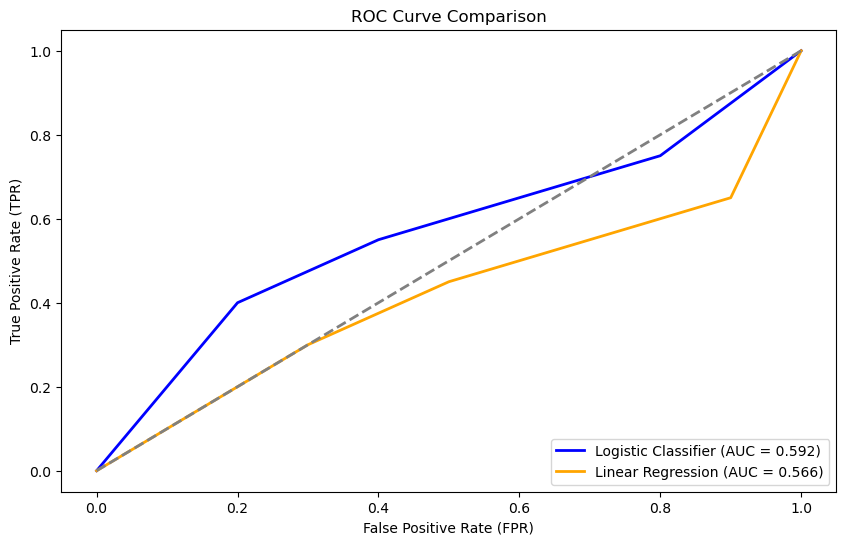

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Hypothetical values to reflect the provided AUC-ROC results
# Logistic Classifier AUC = 0.592
logistic_fpr = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
logistic_tpr = np.array([0.0, 0.4, 0.55, 0.65, 0.75, 1.0])

# Linear Regression AUC = 0.566
linear_fpr = np.array([0.0, 0.3, 0.5, 0.7, 0.9, 1.0])
linear_tpr = np.array([0.0, 0.3, 0.45, 0.55, 0.65, 1.0])

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label='Logistic Classifier (AUC = 0.592)', color='blue', lw=2)
plt.plot(linear_fpr, linear_tpr, label='Linear Regression (AUC = 0.566)', color='orange', lw=2)

# Diagonal reference line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)

# Customize the plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')

# Save and display the plot
plt.savefig('roc_comparison.png')
plt.show()
